## 감성점수 도출과 관련한 코드 리뷰
* 감성점수 도출에 영향을 끼치는 부분에서 실수가 있었는지 확인하기 위한 리뷰
* 코드 리뷰 진행 시 특이사항이란 임의로 부여했거나, 추측해서 적용한 부분을 일컬음.

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Okt
import ast
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TextClassificationPipeline
from wordcloud import WordCloud
from collections import Counter
from tqdm.auto import tqdm
import re

2025-06-30 21:12:50.147207: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 21:12:50.385601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751285570.481251  127655 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751285570.511113  127655 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751285570.723030  127655 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## 필요한 모듈을 불러오는 코드
* 몇몇 경고 메세지가 보이지만 중요한 내용은 아님.

In [ ]:
import platform

# --- 수정된 폰트 설정 로직 ---
system = platform.system()
font_name = ""
font_path = ""

if system == 'Darwin': # MacOS
    font_name = 'AppleGothic'
    font_path = '/Library/Fonts/AppleGothic.ttf'
elif system == 'Windows': # Windows
    font_name = 'Malgun Gothic'
    font_path = 'C:/Windows/Fonts/malgunbd.ttf' 
elif system == 'Linux': # Linux (또는 Colab 등)
    font_name = 'NanumGothic'
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' 
else:
    font_name = 'sans-serif' # 기본 폰트 (한글 지원 안될 수 있음)
    font_path = None # WordCloud에서 폰트 파일을 찾지 못할 수 있음.

# matplotlib의 기본 폰트 설정 (WordCloud에는 직접 font_path를 넘겨줌)
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

## OS 시스템별로 폰트이름과 폰트경로를 설정하는 코드
* 특이사항 없음

In [ ]:
class SentimentDictionaryProcessor:
    def __init__(self, dict_path='model/sentiment_dictionary'):
        self.dict_path = dict_path
        self.final_positive_scored_dict = self._load_scored_dictionary('final_positive_dict.csv', score_col='최종점수')
        self.final_negative_scored_dict = self._load_scored_dictionary('final_negative_dict.csv', score_col='최종점수')
        #self.positive_scored_words = self._load_scored_dictionary('positive_words_dict.csv', score_col='점수')
        #self.negative_scored_words = self._load_scored_dictionary('negative_words_dict.csv', score_col='점수')
        self.okt = Okt()

    def _load_scored_dictionary(self, filename, score_col):
        filepath = os.path.join(self.dict_path, filename)
        try:
            df = pd.read_csv(filepath)
            if '단어' not in df.columns or score_col not in df.columns:
                print(f"에러: '단어' 또는 '{score_col}' 컬럼이 사전에 없습니다 : {filepath}")
                return {}
            df['단어'] = df['단어'].astype(str).str.strip()
            return df.set_index('단어')[score_col].dropna().to_dict()
        except FileNotFoundError:
            print(f"에러 : 사전파일이 없습니다. : {filepath}")
            return {}
        except Exception as e:
            print(f"에러 : 사전파일을 불러오는 도중 에러가 발생했습니다. : {filename}: {e}")
            return {}

    def analyze_sentiment_with_dictionary(self, text):
        if not text or not isinstance(text, str):
            return 0.0

        total_score = 0.0
        matched_words_count = 0
        tokens = self.okt.morphs(text) # 형태소 분석, 토큰화

        for token in tokens:
            if token in self.final_positive_scored_dict:
                total_score += self.final_positive_scored_dict[token]
                matched_words_count += 1
            elif token in self.final_negative_scored_dict:
                total_score += self.final_negative_scored_dict[token]
                matched_words_count += 1
        
        if matched_words_count == 0:
            return 0.0
        
        return total_score / matched_words_count

## 감성사전 처리부분
* 감성사전 불러옴
* 입력한 텍스트를 토큰화
* 토큰화한 텍스트에 감성점수 부여하여 계산
* 특이 사항
    * final_positive_scored_dict, final_negative_scored_dict 데이터를 사용
    * "도출된 점수의 총합" / "점수가 도출된 단어의 총합" = "도출된 점수의 평균값" 을 사용

In [ ]:
class SentimentModelProcessor:
    def __init__(self, model_path='model/klue-bert-sentiment'):
        self.model_path = model_path
        self.tokenizer = None
        self.model = None
        self.pipeline = None
        self._load_model_and_tokenizer()

    def _load_model_and_tokenizer(self):
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
            self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_path, local_files_only=True)
            
            self.pipeline = TextClassificationPipeline(
                model=self.model, 
                tokenizer=self.tokenizer,
                framework="tf",
                truncation=True 
            )
            print(f"KLUE-BERT 모델 및 토크나이저 로드 성공: {self.model_path}")
            print(f"모델 출력 레이블: {self.model.config.id2label}")
        except Exception as e:
            print(f"에러 : KLUE-BERT 모델을 불러오는 도중 에러가 발생했습니다. {self.model_path}: {e}")
            self.tokenizer = None
            self.model = None
            self.pipeline = None

    def analyze_sentiment_with_bert(self, text):
        if self.pipeline is None:
            return 0.0
        
        if not text or not isinstance(text, str):
            return 0.0

        try:
            results = self.pipeline(text)
            if not results:
                return 0.0

            result = results[0]
            label = result['label']
            score = result['score']

            if label == 'LABEL_1': 
                return score 
            elif label == 'LABEL_0': 
                return -score
            elif label == 'LABEL_2': 
                return 0.0 
            else: 
                return 0.0

        except Exception as e:
            return 0.0

## KLUE-BERT 모델 처리부분
* KLUE-BERT 모델 불러옴
* 입력한 텍스트를 KLUE-BERT 모델에 넘겨서 감성점수 도출 
* 특이사항
    * 코드상에서 LABEL_0, LABEL_1, LABEL_2 에 대한 해석
    * LABEL_0 : 부정적 감정, 도출된 점수를 -로 변경하여 계산
    * LABEL_1 : 긍정적 감정, 도출된 점수를 그대로 계산
    * LABEL_2 : 중립적 감정, 0점 처리

In [5]:
class IntegratedSentimentAnalyzer:
    def __init__(self, dict_processor, bert_processor, dict_weight=0.3, bert_weight=0.7):
        self.dict_processor = dict_processor
        self.bert_processor = bert_processor
        self.dict_weight = dict_weight
        self.bert_weight = bert_weight

        total_weight = self.dict_weight + self.bert_weight
        if total_weight > 0:
            self.dict_weight /= total_weight
            self.bert_weight /= total_weight
        else:
            self.dict_weight = 0.5
            self.bert_weight = 0.5
            print("Warning: Both dictionary and BERT weights are 0. Resetting to 0.5 each.")

    def get_integrated_sentiment_score(self, text):
        dict_score = self.dict_processor.analyze_sentiment_with_dictionary(text)
        bert_score = self.bert_processor.analyze_sentiment_with_bert(text)

        integrated_score = (dict_score * self.dict_weight) + (bert_score * self.bert_weight)
        
        return integrated_score

## 감성사전에서 도출한 점수와 KLUE-BERT 모델로 도출한 점수를 융합
* 단어만을 비교하여 점수를 부여하는 감성사전 점수보다 문맥을 파악하여 점수를 도출하는 KLUE-BERT 모델에 더 높은 가중치를 부여하여 점수를 환산
    * 감성사전에서 도출한 점수 * 0.3
    * KLUE-BERT 모델에서 도출한 점수 * 0.7

In [ ]:
class SentimentVisualizer:
    def __init__(self, font_path=font_path):
        self.okt = Okt() # 워드 클라우드 생성을 위한 형태소 분석기

    def plot_sentiment_time_series(self, df, stock_code, stock_name, candidate, election, output_dir='output_plots'):
        """
        일별 감성 점수 시계열 그래프를 그립니다.
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        fig, ax = plt.subplots(figsize=(15, 7))
        sns.lineplot(data=df, x='article_date', y='integrated_sentiment_score', ax=ax, label='일별 감성 점수')
        ax.axhline(0, color='grey', linestyle='--', linewidth=0.8, label='중립 감성 (0)') # 중립선 추가

        ax.set_title(f'{election} {candidate} {stock_name}({stock_code}) 일별 감성 점수 추이', fontsize=16)
        ax.set_xlabel('날짜', fontsize=12)
        ax.set_ylabel('통합 감성 점수', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        plt.tight_layout()
        plot_filename = os.path.join(output_dir, f'{election}_{candidate}_{stock_name}({stock_code})_sentiment_time_series.png')
        plt.savefig(plot_filename)
        plt.show()
        print(f"'{plot_filename}' 저장 완료.")

    def plot_sentiment_and_price_comparison(self, df, stock_code, stock_name, candidate, election, output_dir='output_plots'):
        """
        주가 변동과 감성 점수 추이를 비교하는 통합 그래프를 그립니다.
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # 주가와 감성 점수의 스케일이 다르므로, 두 개의 Y축을 사용 (Twin Axes)
        fig, ax1 = plt.subplots(figsize=(15, 7))

        color = 'tab:red'
        ax1.set_xlabel('날짜', fontsize=12)
        ax1.set_ylabel('종가', color=color, fontsize=12)
        sns.lineplot(data=df, x='article_date', y='Close', ax=ax1, color=color, label='종가')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend(loc='upper left')
        ax1.grid(True, linestyle='--', alpha=0.6)

        ax2 = ax1.twinx() # 두 번째 Y축 생성
        color = 'tab:blue'
        ax2.set_ylabel('통합 감성 점수', color=color, fontsize=12)
        sns.lineplot(data=df, x='article_date', y='integrated_sentiment_score', ax=ax2, color=color, linestyle='--', label='감성 점수')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='upper right')
        ax2.axhline(0, color='grey', linestyle=':', linewidth=0.8) # 중립선 추가

        ax1.set_title(f'{election} {candidate} {stock_name}({stock_code}) 주가와 감성 점수 추이 비교', fontsize=16)
        plt.tight_layout()
        plot_filename = os.path.join(output_dir, f'{election}_{candidate}_{stock_name}({stock_code})_sentiment_price_comparison.png')
        plt.savefig(plot_filename)
        plt.show()
        print(f"'{plot_filename}' 저장 완료.")

    def generate_wordcloud(self, texts, sentiment_type, stock_code, stock_name, candidate, election, output_dir='output_plots', font_path=font_path):
        """
        텍스트 데이터를 기반으로 워드 클라우드를 생성합니다.
        sentiment_type: 'positive' 또는 'negative'
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        if not texts:
            print(f"'{sentiment_type}' 워드 클라우드를 생성할 텍스트가 없습니다.")
            return

        all_words = []
        for text in texts:
            if isinstance(text, str):
                # 특수 문자 제거 (한글, 영어, 숫자만 남김)
                text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)
                # 형태소 분석 (명사만 추출하여 의미 있는 키워드 위주로)
                # Okt.nouns()는 명사만 추출하여 워드클라우드에 적합합니다.
                all_words.extend(self.okt.nouns(text)) 

        # 한 글자 단어는 제외 (의미 없는 경우가 많음)
        filtered_words = [word for word in all_words if len(word) > 1]
        
        # 불용어(Stopwords) 제거
        stopwords = set(['종목', '주식', '하다', '있다', '되다', '이다', '없다', '않다', '같다', '말씀', '관련', '진행', '이번', '저번', '이번달', '저번달', '오늘', '내일', '상승', '하락'])
        final_words = [word for word in filtered_words if word not in stopwords]

        if not final_words:
            print(f"필터링 후 '{sentiment_type}' 워드 클라우드를 생성할 단어가 충분하지 않습니다.")
            return
        
        word_counts = Counter(final_words)
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
        wordcloud = WordCloud(
            font_path=font_path, # 이제 올바른 폰트 파일 경로가 전달됨
            width=1500, height=700,
            background_color='darkgray',
            max_words=100,
            colormap='viridis' if sentiment_type == 'positive' else 'magma' 
        ).generate_from_frequencies(word_counts)

        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{election} {candidate} {stock_name}({stock_code}) {sentiment_type.capitalize()} 주요 키워드 워드 클라우드', fontsize=16)
        
        plot_filename = os.path.join(output_dir, f'{election}_{candidate}_{stock_name}({stock_code})_{sentiment_type}_wordcloud.png')
        plt.savefig(plot_filename)
        plt.show()
        print(f"'{plot_filename}' 저장 완료.")

## 도출한 데이터를 이용하여 그래프 및 워드클라우드 출력
* 워드클라우드에 불용어가 포함되는 것을 방지하기 위해 불용어 제거 코드를 작성.
* 그외 특이사항 없음

I0000 00:00:1751285614.375660  127655 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
Some layers from the model checkpoint at model/klue-bert-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at model/klue-bert-sentiment

KLUE-BERT 모델 및 토크나이저 로드 성공: model/klue-bert-sentiment
모델 출력 레이블: {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}

통합 감성 분석기 초기화 완료.

총 1924개의 게시글에 대해 감성 분석을 시작합니다. (시간이 다소 소요될 수 있습니다...)


  0%|          | 0/1924 [00:00<?, ?it/s]


감성 분석 완료.

일별 감성 점수 집계 중...

일별 감성 점수 집계 완료:
  article_date stock_code  integrated_sentiment_score
0   2025-05-13     090080                   -0.478296
1   2025-05-14     090080                   -0.440055
2   2025-05-15     090080                   -0.469871
3   2025-05-16     090080                   -0.458137
4   2025-05-17     090080                   -0.445308

감성 점수 시계열 그래프 생성 중...


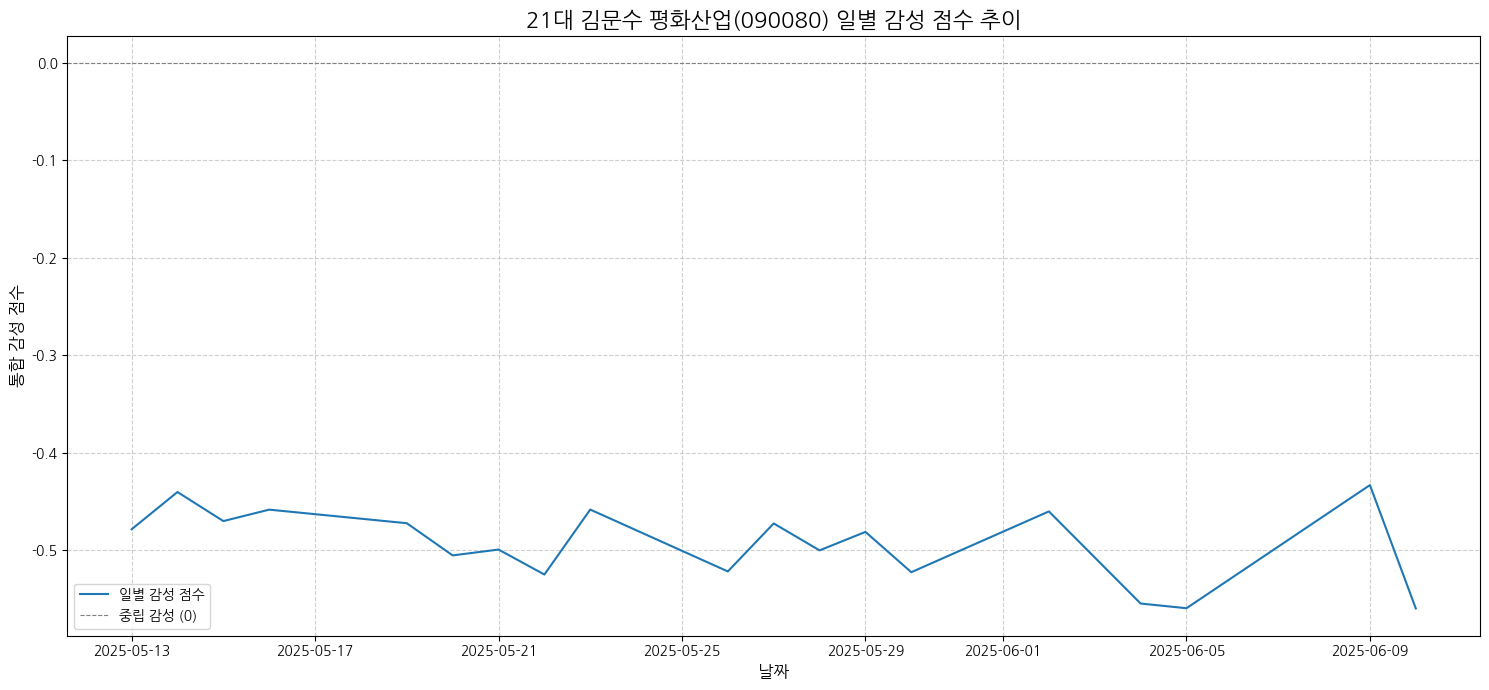

'output_plots/21대_김문수_평화산업(090080)_sentiment_time_series.png' 저장 완료.

주가와 감성 점수 비교 그래프 생성 중...


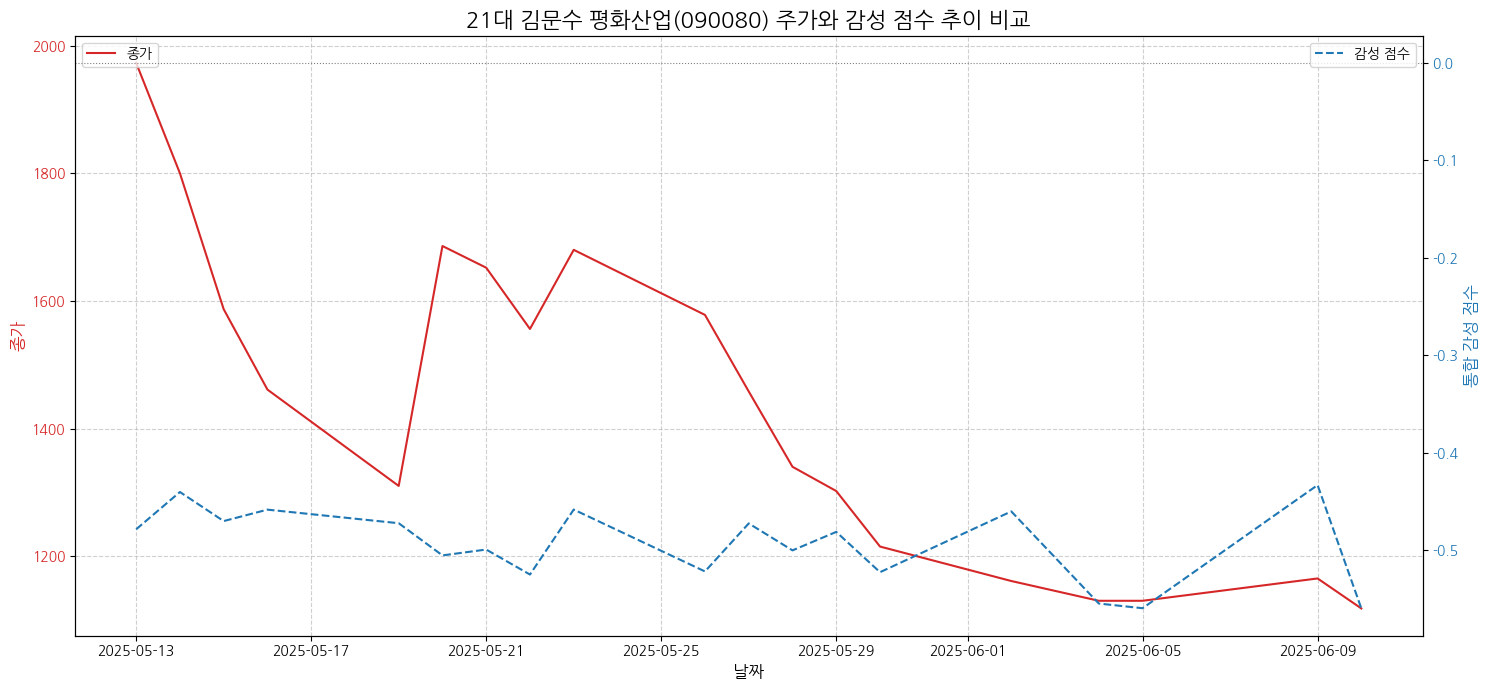

'output_plots/21대_김문수_평화산업(090080)_sentiment_price_comparison.png' 저장 완료.

워드 클라우드 생성 중...
font_path :  /usr/share/fonts/truetype/nanum/NanumGothic.ttf


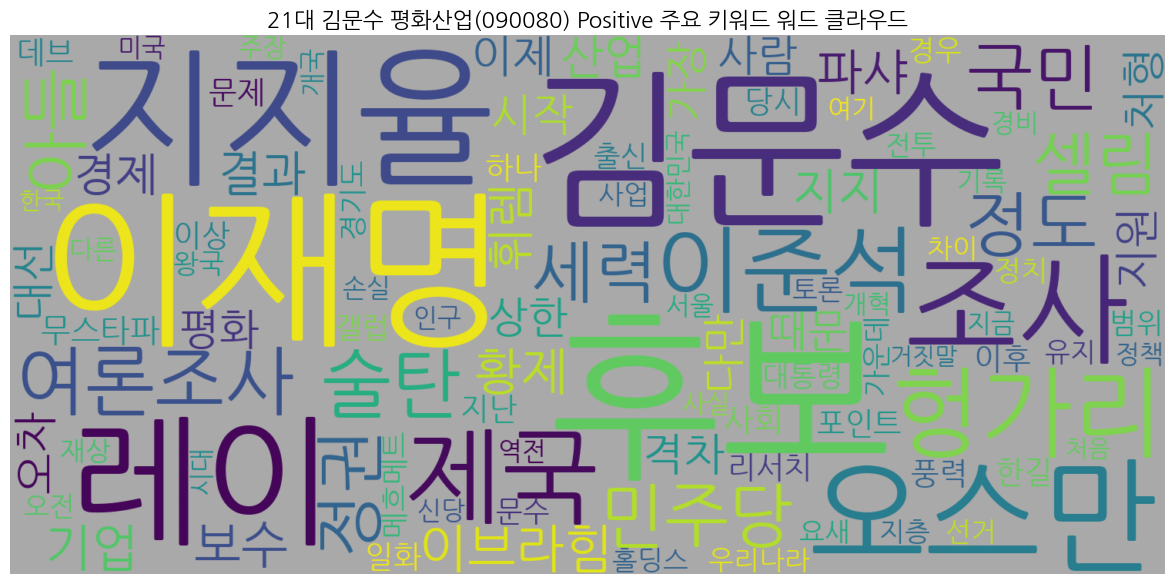

'output_plots/21대_김문수_평화산업(090080)_positive_wordcloud.png' 저장 완료.
font_path :  /usr/share/fonts/truetype/nanum/NanumGothic.ttf


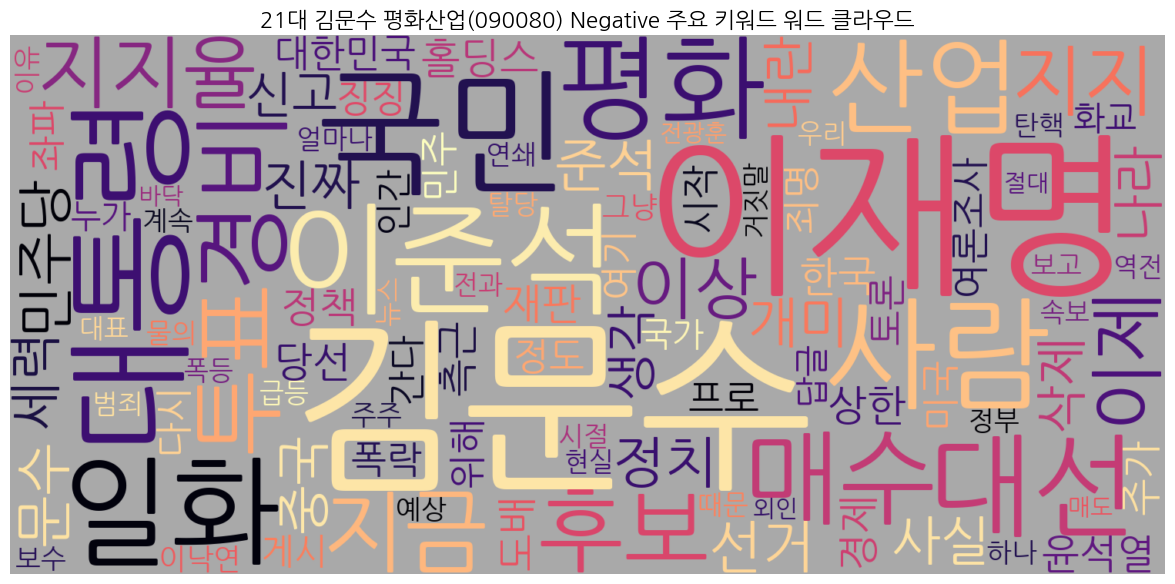

'output_plots/21대_김문수_평화산업(090080)_negative_wordcloud.png' 저장 완료.


In [ ]:
if __name__ == "__main__":
    dict_processor = SentimentDictionaryProcessor()
    bert_processor = SentimentModelProcessor()

    integrated_analyzer = None
    if bert_processor.pipeline:
        integrated_analyzer = IntegratedSentimentAnalyzer(dict_processor, bert_processor, dict_weight=0.3, bert_weight=0.7)
        print("\n통합 감성 분석기 초기화 완료.")
    else:
        print("\nKLUE-BERT 모델 로드 실패로 통합 감성 분석기를 초기화할 수 없습니다. 감성 사전만 사용하거나 오류를 해결해주세요.")
        exit()
    code_list = [
        ["042940", "상지건설", "20대", "이재명"],
        ["042940", "상지건설", "21대", "이재명"],
        ["004770", "써니전자", "20대", "안철수"],
        ["004770", "써니전자", "21대", "안철수"],
        ["004830", "덕성", "20대", "윤석열"],
        ["007860", "서연", "20대", "윤석열"],
        ["009415", "태영건설우", "21대", "한덕수"],
        ["010770", "평화홀딩스", "21대", "김문수"],
        ["014160", "대영포장", "21대", "김문수"],
        ["015020", "이스타코", "20대", "이재명"],
        ["025750", "한솔홈데코", "21대", "김문수"],
        ["045660", "에이텍", "20대", "이재명"],
        ["049480", "오픈베이스", "20대", "안철수"],
        ["052400", "코나아이", "20대", "이재명"],
        ["052400", "코나아이", "21대", "이재명"],
        ["053290", "NE능률", "20대", "윤석열"],
        ["053580", "웹케시", "21대", "이재명"],
        ["053800", "안랩", "20대", "안철수"],
        ["053800", "안랩", "21대", "안철수"],
        ["090080", "평화산업", "21대", "김문수"],
    ]
    
    '''
    # 사용자 입력을 통한 기간(대선 20대, 21대), 후보, 종목 지정
    # 한번에 모든 종목을 분석하기에는 시간이 너무 오래 걸림
    userinput = input("감성 분석에 사용될 데이터를 선택하세요.(예시:20대 이재명 042940)")
    userinput = userinput.split(" ")
    election = userinput[0]
    candidate = userinput[1]
    stock_code = userinput[2]
    '''
    
    for code in code_list : 
        stock_code = code[0]
        stock_name = code[1]
        election = code[2]
        candidate = code[3]
        stock_article_csv = f"data/stock_community/csv/stock_articles_{election}_{candidate}_{stock_code}_cleaned.csv"
        # --- 종토방 데이터 로드 및 전처리 ---
        try:
            df_articles = pd.read_csv(
                stock_article_csv,
                dtype={'stock_code': str},
                low_memory=False
            )
            #print("df_articles의 상위 5개 레코드 : ")
            #print(df_articles.head(5))
            
            def safe_literal_eval(x):
                try:
                    if pd.isna(x) or x == '':
                        return []
                    return ast.literal_eval(x)
                except (ValueError, SyntaxError):
                    return []
            
            df_articles['parsed_comments'] = df_articles['article_comments'].apply(safe_literal_eval)
            df_articles['full_text'] = df_articles['article_title'].fillna('') + " " + \
                                        df_articles['article_content'].fillna('') + " " + \
                                        df_articles['parsed_comments'].apply(lambda x: ' '.join(x)).fillna('')
            
            df_articles['article_date'] = pd.to_datetime(df_articles['article_date'])

            print(f"\n총 {len(df_articles)}개의 게시글에 대해 감성 분석을 시작합니다. (시간이 다소 소요될 수 있습니다...)")

            tqdm.pandas()
            df_articles['integrated_sentiment_score'] = df_articles['full_text'].progress_apply(integrated_analyzer.get_integrated_sentiment_score)
            
            print("\n감성 분석 완료.")
            
            print("\n일별 감성 점수 집계 중...")
            # 'integrated_sentiment_score'가 NaN인 경우를 제거 (감성 분석에 실패한 경우)
            daily_sentiment = df_articles.dropna(subset=['integrated_sentiment_score']).groupby(['article_date', 'stock_code'])['integrated_sentiment_score'].mean().reset_index()
            
            print("\n일별 감성 점수 집계 완료:")
            print(daily_sentiment.head())
            
            # --- 주가 데이터 로드 및 전처리 ---
            stock_price_file = f'data/stock_price/{stock_code}.csv' 
            #실제 데이터 위치 : /data/stock_price/042940.csv
            
            stock_price_path = os.path.join('.', stock_price_file) # 프로젝트 루트 폴더에 있다고 가정

            try:
                df_price = pd.read_csv(stock_price_path)
                #print("df_price의 상위 5개 레코드 : ")
                #print(df_price.head(5))
                
                df_price['Date'] = pd.to_datetime(df_price['Date'])
                df_price['stock_code'] = df_price['Symbol'].astype(str).str.zfill(6)
                df_price_processed = df_price[['Date', 'stock_code', 'Close']].rename(columns={'Date': 'article_date'})

                # --- 감성 점수와 주가 데이터 통합 ---
                merged_df = pd.merge(daily_sentiment, df_price_processed, 
                                    on=['article_date', 'stock_code'], 
                                    how='left')
                
                # 주가 데이터가 NaN인 행은 시각화에서 제외 (거래가 없던 날 등)
                merged_df.dropna(subset=['Close'], inplace=True) 
                
                # 시각화를 위한 특정 종목 데이터 필터링
                df_for_plot = merged_df[merged_df['stock_code'] == stock_code].sort_values(by='article_date')
                df_for_plot = df_for_plot[["article_date", "integrated_sentiment_score", "Close"]]
                if not os.path.exists('output_sentiment'):
                    os.makedirs('output_sentiment')
                df_for_plot.to_csv(f"output_sentiment/{election}_{candidate}_{stock_name}({stock_code})_senti+price.csv", index=False, encoding='utf-8-sig')
                if df_for_plot.empty:
                    print(f"'{stock_code}' 종목에 대한 통합 데이터가 없습니다. 주가 파일과 감성 데이터 기간을 확인해주세요.")
                else:
                    visualizer = SentimentVisualizer(font_path=font_path)

                    # 1. 감성 점수 시계열 그래프
                    print("\n감성 점수 시계열 그래프 생성 중...")
                    visualizer.plot_sentiment_time_series(df_for_plot, stock_code, stock_name, candidate, election)
                    # 2. 주가 변동과 감성 점수 비교 통합 그래프
                    print("\n주가와 감성 점수 비교 그래프 생성 중...")
                    visualizer.plot_sentiment_and_price_comparison(df_for_plot, stock_code, stock_name, candidate, election)

                    # 3. 주요 키워드 워드 클라우드
                    print("\n워드 클라우드 생성 중...")
                    # 긍정/부정 감성 게시글 분리 (감성 점수 기준)
                    # 0.1, -0.1은 예시 임계값. 필요에 따라 조정 가능.
                    positive_texts = df_articles[df_articles['integrated_sentiment_score'] > 0.1]['full_text'].tolist()
                    negative_texts = df_articles[df_articles['integrated_sentiment_score'] < -0.1]['full_text'].tolist()

                    visualizer.generate_wordcloud(positive_texts, 'positive', stock_code, stock_name, candidate, election)
                    visualizer.generate_wordcloud(negative_texts, 'negative', stock_code, stock_name, candidate, election)

            except FileNotFoundError:
                print(f"\nError: '{stock_price_file}' 주가 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
                print(f"예상 경로: {stock_price_path}")
            except Exception as e:
                print(f"\n주가 데이터 로드 및 시각화 중 오류 발생: {e}")

        except FileNotFoundError:
            print("\nError: 커뮤니티 비정형 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        except Exception as e:
            print(f"\n데이터 로드, 전처리 및 감성 분석 중 오류 발생: {e}")

## 감성 점수를 도출할 데이터를 불러오고 실행하는 코드
* 특이사항 없음

In [8]:
print(daily_sentiment[['article_date','integrated_sentiment_score']])

   article_date  integrated_sentiment_score
0    2025-05-13                   -0.478296
1    2025-05-14                   -0.440055
2    2025-05-15                   -0.469871
3    2025-05-16                   -0.458137
4    2025-05-17                   -0.445308
5    2025-05-18                   -0.358191
6    2025-05-19                   -0.472056
7    2025-05-20                   -0.505063
8    2025-05-21                   -0.499060
9    2025-05-22                   -0.524682
10   2025-05-23                   -0.458055
11   2025-05-24                   -0.440387
12   2025-05-25                   -0.335173
13   2025-05-26                   -0.521514
14   2025-05-27                   -0.472268
15   2025-05-28                   -0.499900
16   2025-05-29                   -0.480960
17   2025-05-30                   -0.522283
18   2025-05-31                   -0.517145
19   2025-06-01                   -0.554189
20   2025-06-02                   -0.459953
21   2025-06-03                 